## Histogram

* Мы построим гистограмму, чтобы сравнить абсолютное количество коммитов в рабочие дни и выходные.

#### 1. Подключаемся к базе

In [21]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

conn = sqlite3.connect('../data/checking-logs.sqlite')

#### 2. Загрузка данных

In [22]:
query = """
SELECT timestamp
FROM checker
WHERE uid NOT LIKE 'admin%' AND labname IS NOT NULL
"""
df = pd.read_sql_query(query, conn)
df.head()

,timestamp
0,2020-04-17 05:19:02.744528
1,2020-04-17 05:22:35.249331
2,2020-04-17 05:22:45.549397
3,2020-04-17 05:34:14.691200
4,2020-04-17 05:34:24.422370


#### 3. Обработка данных

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['day_of_week'] = df['timestamp'].dt.day_name()
df['hour'] = df['timestamp'].dt.hour

df.head()

,timestamp,day_of_week,hour
0,2020-04-17 05:19:02.744528,Friday,5
1,2020-04-17 05:22:35.249331,Friday,5
2,2020-04-17 05:22:45.549397,Friday,5
3,2020-04-17 05:34:14.691200,Friday,5
4,2020-04-17 05:34:24.422370,Friday,5


In [24]:
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

df.head()

,timestamp,day_of_week,hour,is_weekend
0,2020-04-17 05:19:02.744528,Friday,5,False
1,2020-04-17 05:22:35.249331,Friday,5,False
2,2020-04-17 05:22:45.549397,Friday,5,False
3,2020-04-17 05:34:14.691200,Friday,5,False
4,2020-04-17 05:34:24.422370,Friday,5,False


In [25]:
working_days = df[df['is_weekend'] == False]['hour'].value_counts().sort_index()
weekends = df[df['is_weekend'] == True]['hour'].value_counts().sort_index()

print(working_days.to_string())
print(weekends.to_string())

hour
0       6
3       2
5      15
6       3
7      31
8      37
9      30
10    131
11     88
12     79
13     72
14    121
15    140
16    170
17    192
18    167
19    214
20    183
21    292
22     45
23     15
hour
0       6
1       6
3       1
5       2
7      16
8      28
9      21
10     27
11    118
12     57
13    108
14     86
15    114
16     74
17     49
18     61
19    103
20    116
21     72
22     59
23     32


In [26]:
working_days_list = [working_days.get(hour, 0) for hour in range(24)]
weekends_list = [weekends.get(hour, 0) for hour in range(24)]

print(working_days_list)
print(weekends_list)

[np.int64(6), 0, 0, np.int64(2), 0, np.int64(15), np.int64(3), np.int64(31), np.int64(37), np.int64(30), np.int64(131), np.int64(88), np.int64(79), np.int64(72), np.int64(121), np.int64(140), np.int64(170), np.int64(192), np.int64(167), np.int64(214), np.int64(183), np.int64(292), np.int64(45), np.int64(15)]
[np.int64(6), np.int64(6), 0, np.int64(1), 0, np.int64(2), 0, np.int64(16), np.int64(28), np.int64(21), np.int64(27), np.int64(118), np.int64(57), np.int64(108), np.int64(86), np.int64(114), np.int64(74), np.int64(49), np.int64(61), np.int64(103), np.int64(116), np.int64(72), np.int64(59), np.int64(32)]


#### 4. Потсроение гистограмы

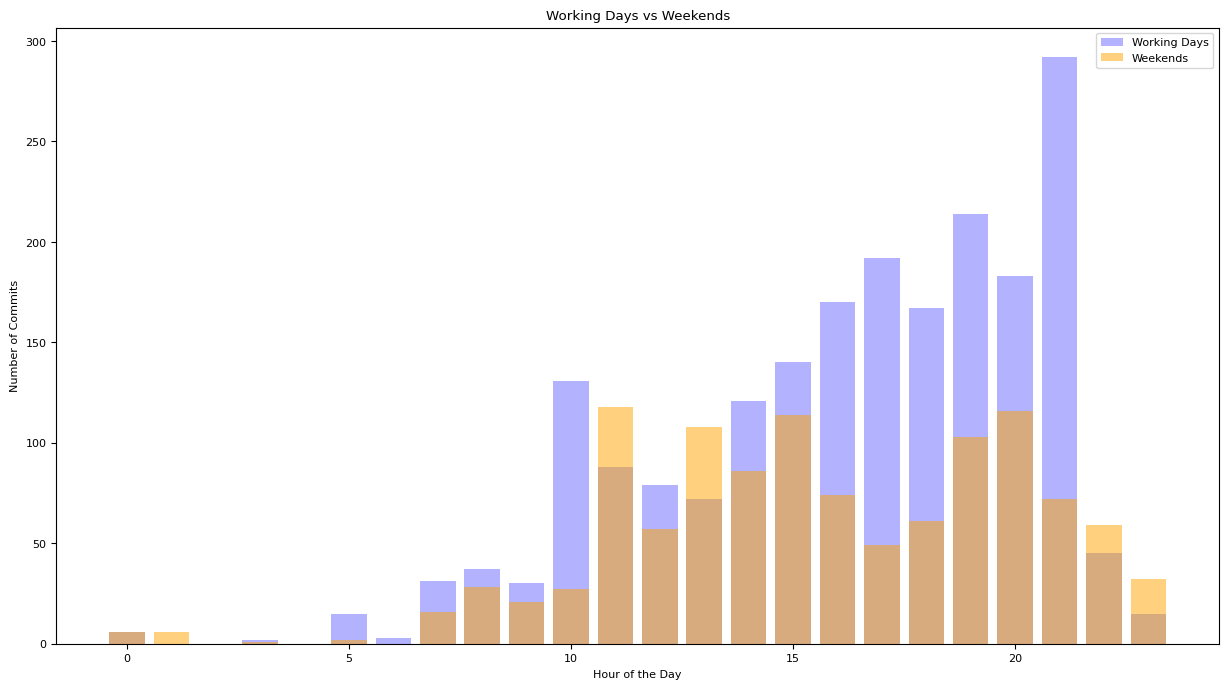

In [27]:
plt.rcParams['font.size'] = 8
plt.figure(figsize=(15, 8))

plt.bar(range(24), working_days_list, label='Working Days', color='blue', alpha=0.3)
plt.bar(range(24), weekends_list, label='Weekends', color='orange', alpha=0.5)

plt.title('Working Days vs Weekends')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Commits')

plt.legend()

plt.show()

#### 5. Отвечаем на допы:

* “Are there hours when the total number of commits was higher on weekends than
on working days?”

In [28]:
comparison = pd.Series(weekends_list) - pd.Series(working_days_list)

higher_on_weekends = comparison[comparison > 0].sort_values(ascending=False)

top_4_hours = higher_on_weekends.head(4)
print("The answer is:")
for hour, diff in top_4_hours.items():
    print(f"Hour {hour}: {diff} more commits on weekends")

The answer is:
Hour 13: 36 more commits on weekends
Hour 11: 30 more commits on weekends
Hour 23: 17 more commits on weekends
Hour 22: 14 more commits on weekends


In [29]:
conn.close()